In [15]:
filename="./Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt"
file = open(filename, 'r')
doc = file.read()

In [2]:
doc

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .\n1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a painted rainbow with her hands in 

In [3]:
descriptions={}
for line in doc.split('\n')[:-2]:
    tokens=line.split()
    
    image_id=tokens[0]
    image_des=tokens[1:]
    
    image_id=image_id.split(".")[0]
    image_des=' '.join(image_des)
    if image_id not in descriptions:
        descriptions[image_id]=[]
    descriptions[image_id].append(image_des)

In [4]:
descriptions

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'There is a gi

In [6]:
print(len(descriptions))
print(len(descriptions['1009434119_febe49276a']))

8092
5


In [17]:
def clean_desc(descriptions):
    for key,desc_list in descriptions.items():
        for i in range(len(desc_list)):
            des=desc_list[i]
            desc_list[i]= ' '.join([word.lower() for word in des.split() if word.isalpha() and len(word)>1])
    return descriptions

In [18]:
descriptions=clean_desc(descriptions)
descriptions

{'1000268201_693b08cb0e': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70': ['black dog and spotted dog are fighting',
  'black dog and dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large painted rainbow',
  'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
  'there is girl with pigtails sitting in front of rainbow painting',
  'young girl with pigtails pain

In [19]:
vocabulary = set()
for key in descriptions.keys():
    [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8357


In [91]:
all_cap=[]
for val in descriptions.values():
    for x in val:
        all_cap.append(x)

In [92]:
all_cap[:5]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [93]:
word_cnt={}
for sent in all_cap:
    for w in sent.split():
        word_cnt[w]=word_cnt.get(w,0)+1

In [94]:
print(word_cnt['child'])

1545


In [95]:
vocab=[w for w in word_cnt if word_cnt[w]>=10]
print(len(vocab))

1936


In [30]:
with open("descriptions.txt","w") as f:
    f.write(str(descriptions))

In [90]:
import json
descriptions=None
with open("descriptions.txt","r") as f:
    descriptions=f.read()
descriptions=json.loads(descriptions.replace("'","\""))
print(type(descriptions))

<class 'dict'>


In [84]:
train_descriptions={}
with open("./Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt","r") as f:
    train=[w.split(".")[0] for w in f.read().split("\n")[:-1]]

In [44]:
for token in train:
    train_descriptions[token]=[]
    for sent in descriptions[token]:
        sent= "startseq "+sent+" endseq"
        train_descriptions[token].append(sent)

In [46]:
with open("train_descriptions.txt","w") as f:
    f.write(str(train_descriptions))

In [47]:
print(len(train))

6000


### Text Preprocessing done..

In [131]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import ResNet50
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

In [58]:
base_model=ResNet50(weights='imagenet',input_shape=(224,224,3))

102858752/102853048 [==============================] - 107s 1us/step


In [59]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [65]:
base_model.layers[-2]

In [62]:

model=Model(inputs=base_model.input,outputs=base_model.layers[-2].output)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [235]:
def preprocess_img(img):
    img=image.load_img(img,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    img=preprocess_input(img)
    return img

In [79]:
img_path="./Flickr_Data/Flickr_Data/Images/"

In [69]:
img=preprocess_img(img_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


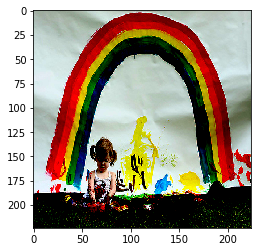

In [70]:
plt.imshow(img[0])

In [236]:
def encode_img(img):
    img=preprocess_img(img)
    feature_vector=model.predict(img)
    feature_vector=feature_vector.reshape((-1,))
    return feature_vector

In [76]:
fv=model.predict(img,batch_size=1)
print(fv.shape)

(1, 2048)


In [78]:
enc=encode_img(img_path)
print(enc.shape)

(2048,)


In [86]:
from tqdm import tqdm
encoding_train={}


In [87]:
for ix,img_id in tqdm(enumerate(train)):
    cur_imgpath=img_path+img_id+".jpg"
    encoding_train[img_id]=encode_img(cur_imgpath)
    if(ix%100==0):
        print("time step %d" %ix)


0it [00:00, ?it/s]

time step 0


100it [00:32,  3.46it/s]

time step 100


200it [01:06,  2.54it/s]

time step 200


300it [01:44,  2.76it/s]

time step 300


400it [02:19,  3.09it/s]

time step 400


500it [02:54,  2.83it/s]

time step 500


600it [03:28,  3.00it/s]

time step 600


700it [04:06,  2.36it/s]

time step 700


800it [04:39,  3.19it/s]

time step 800


900it [05:11,  3.24it/s]

time step 900


1000it [05:41,  2.86it/s]

time step 1000


1100it [06:12,  3.47it/s]

time step 1100


1200it [06:42,  3.47it/s]

time step 1200


1300it [07:18,  2.63it/s]

time step 1300


1400it [07:51,  2.79it/s]

time step 1400


1500it [08:19,  3.29it/s]

time step 1500


1600it [08:49,  3.38it/s]

time step 1600


1700it [09:19,  3.70it/s]

time step 1700


1800it [09:48,  3.52it/s]

time step 1800


1900it [10:29,  2.52it/s]

time step 1900


2000it [10:59,  3.77it/s]

time step 2000


2100it [11:36,  3.10it/s]

time step 2100


2200it [12:20,  1.79it/s]

time step 2200


2300it [13:02,  2.86it/s]

time step 2300


2400it [13:34,  3.54it/s]

time step 2400


2500it [14:08,  3.21it/s]

time step 2500


2600it [14:40,  3.13it/s]

time step 2600


2700it [15:18,  2.36it/s]

time step 2700


2800it [15:48,  3.37it/s]

time step 2800


2900it [16:20,  2.77it/s]

time step 2900


3000it [16:54,  2.69it/s]

time step 3000


3100it [17:28,  2.96it/s]

time step 3100


3200it [18:03,  3.24it/s]

time step 3200


3300it [18:34,  3.64it/s]

time step 3300


3400it [19:05,  2.99it/s]

time step 3400


3500it [19:38,  3.59it/s]

time step 3500


3600it [20:10,  2.88it/s]

time step 3600


3700it [20:42,  3.70it/s]

time step 3700


3800it [21:15,  3.11it/s]

time step 3800


3900it [21:45,  3.55it/s]

time step 3900


4000it [22:18,  3.62it/s]

time step 4000


4100it [22:48,  3.54it/s]

time step 4100


4200it [23:20,  3.41it/s]

time step 4200


4300it [23:49,  2.36it/s]

time step 4300


4400it [24:34,  2.47it/s]

time step 4400


4500it [25:15,  2.44it/s]

time step 4500


4600it [26:01,  3.17it/s]

time step 4600


4700it [26:34,  3.52it/s]

time step 4700


4800it [27:13,  2.17it/s]

time step 4800


4900it [27:54,  3.05it/s]

time step 4900


5000it [28:27,  3.73it/s]

time step 5000


5100it [29:07,  1.25it/s]

time step 5100


5200it [29:52,  2.29it/s]

time step 5200


5300it [30:34,  2.39it/s]

time step 5300


5400it [31:21,  1.93it/s]

time step 5400


5500it [32:07,  1.95it/s]

time step 5500


5600it [32:52,  2.36it/s]

time step 5600


5700it [33:40,  2.24it/s]

time step 5700


5800it [34:17,  3.50it/s]

time step 5800


5900it [34:46,  3.08it/s]

time step 5900


6000it [35:19,  3.06it/s]


In [89]:
import pickle
with open ("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [109]:
vocab.append("startseq")
vocab.append("endseq")

In [125]:
print(len(vocab))

1938


In [111]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [164]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

In [222]:
def data_generator(train_descriptions, train_encoded, wordtoix, max_length=35, num_photos_per_batch=3):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in train_descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = train_encoded[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]-1
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=len(vocab)+1)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
                
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
#mergesort,quicksort,kruskals,prims (daa lab)

In [113]:
f=open("./glove.6B.200d.txt",encoding="utf8")

In [115]:
embedding_index={}
for line in f:
    values=line.split()
    word,embedding=values[0],values[1:]
    embedding_index[word]=np.array(embedding,dtype="float")

In [118]:
embedding_index['apple'].shape

(200,)

In [210]:
def emb_matrix():
    matrix=np.zeros((len(vocab)+1,200))
    for word,ix in wordtoix.items():
        if embedding_index.get(word) is not None:
            matrix[ix]=embedding_index[word]
    return matrix

In [211]:
embedding_matrix=emb_matrix()
embedding_matrix.shape

(1939, 200)

In [129]:
f.close()

### Model architecture

In [141]:
from keras.layers import Dropout,Input,Embedding,LSTM,add

In [215]:
vocab_size=len(vocab)
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# partial caption sequence model
inputs2 = Input(shape=(35,))
se1 = Embedding(vocab_size+1,200, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder (feed forward) model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size+1, activation='softmax')(decoder2)

# merge the two input models
final_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [216]:
final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 35)           0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 35, 200)      387800      input_15[0][0]                   
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 2048)         0           input_14[0][0]                   
__________________________________________________________________________________________________
dropout_9 

In [217]:
final_model.layers[2].set_weights([embedding_matrix])
final_model.layers[2].trainable= False

In [218]:
final_model.compile(loss="categorical_crossentropy",optimizer="Adam")

In [148]:
with open("train_descriptions.txt","r") as f:
    train_descriptions=f.read()
train_descriptions=json.loads(train_descriptions.replace("'","\""))
print(type(train_descriptions))

<class 'dict'>


In [156]:
with open("encoded_train_features.pkl", 'rb') as pickle_file:
    train_encoded = pickle.load(pickle_file)
print(type(train_encoded))

<class 'dict'>


In [225]:
def train_final_model(epochs=20,steps=200):
    for i in range(epochs):
        generator=data_generator(train_descriptions, train_encoded, wordtoix)
        final_model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    final_model.save('final_mod.h5')

In [226]:
train_final_model()

Epoch 1/1
200/200 [==============================] - ETA: 1:08 - loss: 4.100 - ETA: 1:03 - loss: 3.964 - ETA: 1:01 - loss: 4.090 - ETA: 1:00 - loss: 4.374 - ETA: 59s - loss: 4.435 - ETA: 1:00 - loss: 4.536 - ETA: 59s - loss: 4.513 - ETA: 1:00 - loss: 4.499 - ETA: 1:00 - loss: 4.531 - ETA: 1:00 - loss: 4.564 - ETA: 58s - loss: 4.546 - ETA: 58s - loss: 4.57 - ETA: 58s - loss: 4.61 - ETA: 58s - loss: 4.64 - ETA: 57s - loss: 4.69 - ETA: 57s - loss: 4.70 - ETA: 58s - loss: 4.68 - ETA: 59s - loss: 4.70 - ETA: 59s - loss: 4.69 - ETA: 59s - loss: 4.69 - ETA: 58s - loss: 4.66 - ETA: 58s - loss: 4.64 - ETA: 57s - loss: 4.66 - ETA: 57s - loss: 4.65 - ETA: 56s - loss: 4.66 - ETA: 55s - loss: 4.64 - ETA: 55s - loss: 4.64 - ETA: 54s - loss: 4.63 - ETA: 54s - loss: 4.64 - ETA: 53s - loss: 4.65 - ETA: 53s - loss: 4.65 - ETA: 53s - loss: 4.65 - ETA: 52s - loss: 4.65 - ETA: 52s - loss: 4.66 - ETA: 52s - loss: 4.64 - ETA: 51s - loss: 4.64 - ETA: 51s - loss: 4.64 - ETA: 51s - loss: 4.63 - ETA: 51s - loss:

200/200 [==============================] - ETA: 1:33 - loss: 3.856 - ETA: 1:36 - loss: 3.752 - ETA: 1:37 - loss: 3.850 - ETA: 1:30 - loss: 4.073 - ETA: 1:24 - loss: 4.125 - ETA: 1:25 - loss: 4.230 - ETA: 1:23 - loss: 4.206 - ETA: 1:22 - loss: 4.192 - ETA: 1:22 - loss: 4.206 - ETA: 1:21 - loss: 4.232 - ETA: 1:19 - loss: 4.197 - ETA: 1:18 - loss: 4.227 - ETA: 1:18 - loss: 4.269 - ETA: 1:17 - loss: 4.291 - ETA: 1:17 - loss: 4.341 - ETA: 1:17 - loss: 4.349 - ETA: 1:16 - loss: 4.327 - ETA: 1:16 - loss: 4.348 - ETA: 1:16 - loss: 4.339 - ETA: 1:16 - loss: 4.345 - ETA: 1:16 - loss: 4.319 - ETA: 1:17 - loss: 4.300 - ETA: 1:17 - loss: 4.317 - ETA: 1:17 - loss: 4.315 - ETA: 1:16 - loss: 4.326 - ETA: 1:16 - loss: 4.309 - ETA: 1:15 - loss: 4.311 - ETA: 1:15 - loss: 4.299 - ETA: 1:14 - loss: 4.314 - ETA: 1:14 - loss: 4.323 - ETA: 1:14 - loss: 4.315 - ETA: 1:14 - loss: 4.316 - ETA: 1:14 - loss: 4.323 - ETA: 1:13 - loss: 4.328 - ETA: 1:13 - loss: 4.314 - ETA: 1:13 - loss: 4.311 - ETA: 1:13 - loss: 4.3

200/200 [==============================] - ETA: 1:31 - loss: 3.681 - ETA: 1:23 - loss: 3.576 - ETA: 1:22 - loss: 3.670 - ETA: 1:22 - loss: 3.878 - ETA: 1:20 - loss: 3.920 - ETA: 1:21 - loss: 4.009 - ETA: 1:20 - loss: 3.985 - ETA: 1:21 - loss: 3.969 - ETA: 1:21 - loss: 3.973 - ETA: 1:21 - loss: 3.990 - ETA: 1:19 - loss: 3.946 - ETA: 1:20 - loss: 3.972 - ETA: 1:21 - loss: 4.012 - ETA: 1:21 - loss: 4.036 - ETA: 1:21 - loss: 4.091 - ETA: 1:21 - loss: 4.103 - ETA: 1:20 - loss: 4.076 - ETA: 1:19 - loss: 4.097 - ETA: 1:19 - loss: 4.092 - ETA: 1:18 - loss: 4.095 - ETA: 1:16 - loss: 4.065 - ETA: 1:16 - loss: 4.044 - ETA: 1:15 - loss: 4.059 - ETA: 1:14 - loss: 4.061 - ETA: 1:14 - loss: 4.072 - ETA: 1:13 - loss: 4.054 - ETA: 1:12 - loss: 4.058 - ETA: 1:12 - loss: 4.047 - ETA: 1:11 - loss: 4.059 - ETA: 1:11 - loss: 4.066 - ETA: 1:11 - loss: 4.058 - ETA: 1:10 - loss: 4.061 - ETA: 1:11 - loss: 4.070 - ETA: 1:10 - loss: 4.078 - ETA: 1:10 - loss: 4.062 - ETA: 1:10 - loss: 4.061 - ETA: 1:10 - loss: 4.0

200/200 [==============================] - ETA: 1:28 - loss: 3.380 - ETA: 1:41 - loss: 3.342 - ETA: 1:39 - loss: 3.456 - ETA: 1:33 - loss: 3.672 - ETA: 1:32 - loss: 3.682 - ETA: 1:40 - loss: 3.776 - ETA: 1:36 - loss: 3.762 - ETA: 1:33 - loss: 3.743 - ETA: 1:32 - loss: 3.742 - ETA: 1:30 - loss: 3.753 - ETA: 1:28 - loss: 3.716 - ETA: 1:27 - loss: 3.750 - ETA: 1:25 - loss: 3.784 - ETA: 1:23 - loss: 3.813 - ETA: 1:21 - loss: 3.860 - ETA: 1:19 - loss: 3.874 - ETA: 1:18 - loss: 3.848 - ETA: 1:17 - loss: 3.864 - ETA: 1:15 - loss: 3.857 - ETA: 1:14 - loss: 3.861 - ETA: 1:13 - loss: 3.838 - ETA: 1:12 - loss: 3.817 - ETA: 1:11 - loss: 3.834 - ETA: 1:10 - loss: 3.836 - ETA: 1:09 - loss: 3.846 - ETA: 1:08 - loss: 3.829 - ETA: 1:07 - loss: 3.838 - ETA: 1:06 - loss: 3.828 - ETA: 1:06 - loss: 3.839 - ETA: 1:05 - loss: 3.845 - ETA: 1:05 - loss: 3.837 - ETA: 1:04 - loss: 3.840 - ETA: 1:04 - loss: 3.852 - ETA: 1:03 - loss: 3.858 - ETA: 1:02 - loss: 3.844 - ETA: 1:02 - loss: 3.845 - ETA: 1:01 - loss: 3.8

200/200 [==============================] - ETA: 1:30 - loss: 3.252 - ETA: 1:34 - loss: 3.198 - ETA: 1:27 - loss: 3.297 - ETA: 1:22 - loss: 3.484 - ETA: 1:21 - loss: 3.486 - ETA: 1:25 - loss: 3.591 - ETA: 1:28 - loss: 3.580 - ETA: 1:26 - loss: 3.559 - ETA: 1:29 - loss: 3.565 - ETA: 1:31 - loss: 3.570 - ETA: 1:30 - loss: 3.544 - ETA: 1:31 - loss: 3.578 - ETA: 1:29 - loss: 3.608 - ETA: 1:28 - loss: 3.637 - ETA: 1:26 - loss: 3.675 - ETA: 1:24 - loss: 3.695 - ETA: 1:23 - loss: 3.664 - ETA: 1:24 - loss: 3.674 - ETA: 1:23 - loss: 3.670 - ETA: 1:22 - loss: 3.673 - ETA: 1:21 - loss: 3.653 - ETA: 1:20 - loss: 3.634 - ETA: 1:20 - loss: 3.651 - ETA: 1:19 - loss: 3.652 - ETA: 1:18 - loss: 3.661 - ETA: 1:17 - loss: 3.649 - ETA: 1:17 - loss: 3.659 - ETA: 1:17 - loss: 3.647 - ETA: 1:17 - loss: 3.655 - ETA: 1:16 - loss: 3.660 - ETA: 1:15 - loss: 3.651 - ETA: 1:14 - loss: 3.658 - ETA: 1:13 - loss: 3.671 - ETA: 1:12 - loss: 3.675 - ETA: 1:11 - loss: 3.662 - ETA: 1:10 - loss: 3.664 - ETA: 1:10 - loss: 3.6

200/200 [==============================] - ETA: 1:13 - loss: 3.156 - ETA: 1:07 - loss: 3.105 - ETA: 1:10 - loss: 3.196 - ETA: 1:11 - loss: 3.375 - ETA: 1:11 - loss: 3.358 - ETA: 1:12 - loss: 3.457 - ETA: 1:12 - loss: 3.432 - ETA: 1:11 - loss: 3.409 - ETA: 1:12 - loss: 3.413 - ETA: 1:12 - loss: 3.423 - ETA: 1:10 - loss: 3.395 - ETA: 1:09 - loss: 3.429 - ETA: 1:08 - loss: 3.454 - ETA: 1:07 - loss: 3.482 - ETA: 1:06 - loss: 3.525 - ETA: 1:05 - loss: 3.541 - ETA: 1:04 - loss: 3.507 - ETA: 1:03 - loss: 3.515 - ETA: 1:02 - loss: 3.510 - ETA: 1:02 - loss: 3.512 - ETA: 1:01 - loss: 3.491 - ETA: 1:00 - loss: 3.472 - ETA: 1:00 - loss: 3.487 - ETA: 59s - loss: 3.485 - ETA: 59s - loss: 3.49 - ETA: 58s - loss: 3.48 - ETA: 57s - loss: 3.49 - ETA: 57s - loss: 3.47 - ETA: 56s - loss: 3.48 - ETA: 56s - loss: 3.48 - ETA: 56s - loss: 3.48 - ETA: 56s - loss: 3.48 - ETA: 56s - loss: 3.50 - ETA: 56s - loss: 3.50 - ETA: 56s - loss: 3.49 - ETA: 55s - loss: 3.49 - ETA: 55s - loss: 3.48 - ETA: 55s - loss: 3.48 

200/200 [==============================] - ETA: 1:11 - loss: 3.011 - ETA: 1:08 - loss: 2.957 - ETA: 1:11 - loss: 3.075 - ETA: 1:12 - loss: 3.243 - ETA: 1:09 - loss: 3.251 - ETA: 1:10 - loss: 3.352 - ETA: 1:09 - loss: 3.326 - ETA: 1:08 - loss: 3.306 - ETA: 1:07 - loss: 3.319 - ETA: 1:07 - loss: 3.336 - ETA: 1:06 - loss: 3.313 - ETA: 1:05 - loss: 3.347 - ETA: 1:04 - loss: 3.376 - ETA: 1:04 - loss: 3.399 - ETA: 1:03 - loss: 3.441 - ETA: 1:02 - loss: 3.462 - ETA: 1:01 - loss: 3.426 - ETA: 1:00 - loss: 3.435 - ETA: 1:00 - loss: 3.430 - ETA: 59s - loss: 3.428 - ETA: 58s - loss: 3.40 - ETA: 58s - loss: 3.39 - ETA: 58s - loss: 3.40 - ETA: 57s - loss: 3.40 - ETA: 57s - loss: 3.41 - ETA: 56s - loss: 3.39 - ETA: 56s - loss: 3.40 - ETA: 55s - loss: 3.39 - ETA: 55s - loss: 3.39 - ETA: 55s - loss: 3.39 - ETA: 54s - loss: 3.38 - ETA: 54s - loss: 3.39 - ETA: 54s - loss: 3.40 - ETA: 54s - loss: 3.40 - ETA: 54s - loss: 3.39 - ETA: 54s - loss: 3.39 - ETA: 54s - loss: 3.38 - ETA: 54s - loss: 3.37 - ETA: 5

200/200 [==============================] - ETA: 1:13 - loss: 2.912 - ETA: 1:08 - loss: 2.846 - ETA: 1:08 - loss: 2.955 - ETA: 1:07 - loss: 3.146 - ETA: 1:06 - loss: 3.137 - ETA: 1:07 - loss: 3.239 - ETA: 1:07 - loss: 3.217 - ETA: 1:07 - loss: 3.199 - ETA: 1:07 - loss: 3.207 - ETA: 1:07 - loss: 3.227 - ETA: 1:06 - loss: 3.202 - ETA: 1:06 - loss: 3.241 - ETA: 1:06 - loss: 3.261 - ETA: 1:05 - loss: 3.287 - ETA: 1:04 - loss: 3.332 - ETA: 1:04 - loss: 3.349 - ETA: 1:03 - loss: 3.315 - ETA: 1:02 - loss: 3.320 - ETA: 1:02 - loss: 3.315 - ETA: 1:01 - loss: 3.311 - ETA: 1:01 - loss: 3.293 - ETA: 1:01 - loss: 3.278 - ETA: 1:01 - loss: 3.297 - ETA: 1:01 - loss: 3.294 - ETA: 1:01 - loss: 3.299 - ETA: 1:01 - loss: 3.286 - ETA: 1:02 - loss: 3.295 - ETA: 1:01 - loss: 3.276 - ETA: 1:01 - loss: 3.272 - ETA: 1:01 - loss: 3.275 - ETA: 1:01 - loss: 3.266 - ETA: 1:01 - loss: 3.273 - ETA: 1:01 - loss: 3.281 - ETA: 1:00 - loss: 3.284 - ETA: 1:00 - loss: 3.271 - ETA: 59s - loss: 3.270 - ETA: 59s - loss: 3.26 

200/200 [==============================] - ETA: 1:27 - loss: 2.824 - ETA: 1:17 - loss: 2.776 - ETA: 1:14 - loss: 2.856 - ETA: 1:12 - loss: 3.028 - ETA: 1:09 - loss: 2.996 - ETA: 1:11 - loss: 3.084 - ETA: 1:10 - loss: 3.055 - ETA: 1:10 - loss: 3.054 - ETA: 1:09 - loss: 3.066 - ETA: 1:09 - loss: 3.083 - ETA: 1:08 - loss: 3.061 - ETA: 1:08 - loss: 3.098 - ETA: 1:07 - loss: 3.119 - ETA: 1:07 - loss: 3.144 - ETA: 1:06 - loss: 3.189 - ETA: 1:05 - loss: 3.213 - ETA: 1:04 - loss: 3.185 - ETA: 1:04 - loss: 3.195 - ETA: 1:04 - loss: 3.194 - ETA: 1:03 - loss: 3.194 - ETA: 1:03 - loss: 3.178 - ETA: 1:03 - loss: 3.168 - ETA: 1:02 - loss: 3.190 - ETA: 1:02 - loss: 3.193 - ETA: 1:02 - loss: 3.195 - ETA: 1:01 - loss: 3.184 - ETA: 1:00 - loss: 3.190 - ETA: 1:00 - loss: 3.175 - ETA: 59s - loss: 3.176 - ETA: 59s - loss: 3.18 - ETA: 59s - loss: 3.17 - ETA: 59s - loss: 3.18 - ETA: 1:00 - loss: 3.189 - ETA: 1:00 - loss: 3.189 - ETA: 59s - loss: 3.176 - ETA: 59s - loss: 3.17 - ETA: 59s - loss: 3.17 - ETA: 59

200/200 [==============================] - ETA: 1:30 - loss: 2.645 - ETA: 1:25 - loss: 2.646 - ETA: 1:21 - loss: 2.734 - ETA: 1:18 - loss: 2.892 - ETA: 1:14 - loss: 2.870 - ETA: 1:14 - loss: 2.954 - ETA: 1:12 - loss: 2.938 - ETA: 1:11 - loss: 2.933 - ETA: 1:14 - loss: 2.947 - ETA: 1:17 - loss: 2.959 - ETA: 1:16 - loss: 2.940 - ETA: 1:16 - loss: 2.975 - ETA: 1:15 - loss: 2.989 - ETA: 1:15 - loss: 3.016 - ETA: 1:14 - loss: 3.054 - ETA: 1:13 - loss: 3.078 - ETA: 1:12 - loss: 3.052 - ETA: 1:11 - loss: 3.057 - ETA: 1:10 - loss: 3.061 - ETA: 1:09 - loss: 3.067 - ETA: 1:08 - loss: 3.053 - ETA: 1:08 - loss: 3.041 - ETA: 1:07 - loss: 3.063 - ETA: 1:07 - loss: 3.064 - ETA: 1:06 - loss: 3.066 - ETA: 1:05 - loss: 3.053 - ETA: 1:05 - loss: 3.060 - ETA: 1:04 - loss: 3.043 - ETA: 1:03 - loss: 3.044 - ETA: 1:03 - loss: 3.050 - ETA: 1:03 - loss: 3.047 - ETA: 1:03 - loss: 3.053 - ETA: 1:02 - loss: 3.060 - ETA: 1:02 - loss: 3.060 - ETA: 1:01 - loss: 3.048 - ETA: 1:01 - loss: 3.048 - ETA: 1:00 - loss: 3.0

200/200 [==============================] - ETA: 1:25 - loss: 2.620 - ETA: 1:19 - loss: 2.609 - ETA: 1:29 - loss: 2.709 - ETA: 1:26 - loss: 2.871 - ETA: 1:25 - loss: 2.848 - ETA: 1:29 - loss: 2.919 - ETA: 1:29 - loss: 2.905 - ETA: 1:30 - loss: 2.894 - ETA: 1:30 - loss: 2.896 - ETA: 1:29 - loss: 2.912 - ETA: 1:27 - loss: 2.885 - ETA: 1:26 - loss: 2.931 - ETA: 1:26 - loss: 2.950 - ETA: 1:25 - loss: 2.974 - ETA: 1:26 - loss: 3.008 - ETA: 1:24 - loss: 3.025 - ETA: 1:24 - loss: 3.002 - ETA: 1:24 - loss: 3.013 - ETA: 1:24 - loss: 3.012 - ETA: 1:24 - loss: 3.019 - ETA: 1:24 - loss: 3.013 - ETA: 1:23 - loss: 3.000 - ETA: 1:22 - loss: 3.026 - ETA: 1:20 - loss: 3.027 - ETA: 1:19 - loss: 3.027 - ETA: 1:18 - loss: 3.021 - ETA: 1:16 - loss: 3.027 - ETA: 1:15 - loss: 3.008 - ETA: 1:15 - loss: 3.005 - ETA: 1:14 - loss: 3.006 - ETA: 1:13 - loss: 2.997 - ETA: 1:12 - loss: 3.001 - ETA: 1:11 - loss: 3.004 - ETA: 1:10 - loss: 3.004 - ETA: 1:10 - loss: 2.990 - ETA: 1:09 - loss: 2.993 - ETA: 1:08 - loss: 2.9

200/200 [==============================] - ETA: 1:11 - loss: 2.618 - ETA: 1:08 - loss: 2.637 - ETA: 1:07 - loss: 2.727 - ETA: 1:05 - loss: 2.836 - ETA: 1:04 - loss: 2.789 - ETA: 1:06 - loss: 2.866 - ETA: 1:06 - loss: 2.846 - ETA: 1:08 - loss: 2.842 - ETA: 1:09 - loss: 2.844 - ETA: 1:09 - loss: 2.852 - ETA: 1:07 - loss: 2.826 - ETA: 1:07 - loss: 2.863 - ETA: 1:06 - loss: 2.880 - ETA: 1:06 - loss: 2.899 - ETA: 1:05 - loss: 2.941 - ETA: 1:05 - loss: 2.953 - ETA: 1:06 - loss: 2.929 - ETA: 1:06 - loss: 2.940 - ETA: 1:05 - loss: 2.940 - ETA: 1:04 - loss: 2.941 - ETA: 1:03 - loss: 2.930 - ETA: 1:03 - loss: 2.918 - ETA: 1:02 - loss: 2.941 - ETA: 1:02 - loss: 2.941 - ETA: 1:01 - loss: 2.945 - ETA: 1:01 - loss: 2.937 - ETA: 1:00 - loss: 2.945 - ETA: 1:00 - loss: 2.924 - ETA: 59s - loss: 2.920 - ETA: 59s - loss: 2.92 - ETA: 1:00 - loss: 2.912 - ETA: 1:01 - loss: 2.918 - ETA: 1:01 - loss: 2.921 - ETA: 1:00 - loss: 2.921 - ETA: 1:00 - loss: 2.906 - ETA: 1:00 - loss: 2.907 - ETA: 1:00 - loss: 2.897 

200/200 [==============================] - ETA: 1:08 - loss: 2.590 - ETA: 1:04 - loss: 2.572 - ETA: 1:04 - loss: 2.658 - ETA: 1:03 - loss: 2.749 - ETA: 1:02 - loss: 2.720 - ETA: 1:02 - loss: 2.788 - ETA: 1:02 - loss: 2.767 - ETA: 1:02 - loss: 2.760 - ETA: 1:02 - loss: 2.770 - ETA: 1:02 - loss: 2.786 - ETA: 1:01 - loss: 2.757 - ETA: 1:01 - loss: 2.796 - ETA: 1:01 - loss: 2.812 - ETA: 1:00 - loss: 2.827 - ETA: 1:00 - loss: 2.856 - ETA: 59s - loss: 2.871 - ETA: 59s - loss: 2.84 - ETA: 1:00 - loss: 2.856 - ETA: 1:00 - loss: 2.855 - ETA: 1:00 - loss: 2.859 - ETA: 1:00 - loss: 2.848 - ETA: 1:00 - loss: 2.840 - ETA: 59s - loss: 2.863 - ETA: 59s - loss: 2.86 - ETA: 59s - loss: 2.86 - ETA: 59s - loss: 2.85 - ETA: 58s - loss: 2.86 - ETA: 57s - loss: 2.84 - ETA: 57s - loss: 2.84 - ETA: 56s - loss: 2.84 - ETA: 56s - loss: 2.83 - ETA: 56s - loss: 2.84 - ETA: 55s - loss: 2.84 - ETA: 55s - loss: 2.84 - ETA: 54s - loss: 2.83 - ETA: 54s - loss: 2.83 - ETA: 53s - loss: 2.82 - ETA: 53s - loss: 2.80 - ETA

200/200 [==============================] - ETA: 1:20 - loss: 2.394 - ETA: 1:15 - loss: 2.444 - ETA: 1:13 - loss: 2.534 - ETA: 1:12 - loss: 2.641 - ETA: 1:10 - loss: 2.595 - ETA: 1:12 - loss: 2.674 - ETA: 1:13 - loss: 2.672 - ETA: 1:15 - loss: 2.670 - ETA: 1:17 - loss: 2.669 - ETA: 1:19 - loss: 2.687 - ETA: 1:19 - loss: 2.669 - ETA: 1:18 - loss: 2.695 - ETA: 1:19 - loss: 2.710 - ETA: 1:18 - loss: 2.720 - ETA: 1:17 - loss: 2.747 - ETA: 1:15 - loss: 2.764 - ETA: 1:14 - loss: 2.741 - ETA: 1:14 - loss: 2.750 - ETA: 1:13 - loss: 2.747 - ETA: 1:12 - loss: 2.749 - ETA: 1:12 - loss: 2.743 - ETA: 1:12 - loss: 2.735 - ETA: 1:12 - loss: 2.758 - ETA: 1:12 - loss: 2.760 - ETA: 1:11 - loss: 2.762 - ETA: 1:10 - loss: 2.757 - ETA: 1:09 - loss: 2.765 - ETA: 1:09 - loss: 2.749 - ETA: 1:08 - loss: 2.743 - ETA: 1:08 - loss: 2.744 - ETA: 1:07 - loss: 2.738 - ETA: 1:07 - loss: 2.745 - ETA: 1:07 - loss: 2.748 - ETA: 1:06 - loss: 2.744 - ETA: 1:06 - loss: 2.731 - ETA: 1:05 - loss: 2.731 - ETA: 1:05 - loss: 2.7

200/200 [==============================] - ETA: 1:30 - loss: 2.188 - ETA: 1:18 - loss: 2.315 - ETA: 1:16 - loss: 2.378 - ETA: 1:14 - loss: 2.475 - ETA: 1:11 - loss: 2.447 - ETA: 1:11 - loss: 2.514 - ETA: 1:10 - loss: 2.501 - ETA: 1:10 - loss: 2.522 - ETA: 1:10 - loss: 2.533 - ETA: 1:10 - loss: 2.564 - ETA: 1:09 - loss: 2.543 - ETA: 1:09 - loss: 2.581 - ETA: 1:09 - loss: 2.598 - ETA: 1:08 - loss: 2.609 - ETA: 1:07 - loss: 2.631 - ETA: 1:07 - loss: 2.648 - ETA: 1:06 - loss: 2.619 - ETA: 1:05 - loss: 2.634 - ETA: 1:04 - loss: 2.632 - ETA: 1:04 - loss: 2.633 - ETA: 1:04 - loss: 2.628 - ETA: 1:04 - loss: 2.623 - ETA: 1:04 - loss: 2.639 - ETA: 1:04 - loss: 2.644 - ETA: 1:04 - loss: 2.645 - ETA: 1:04 - loss: 2.642 - ETA: 1:03 - loss: 2.642 - ETA: 1:03 - loss: 2.625 - ETA: 1:03 - loss: 2.621 - ETA: 1:02 - loss: 2.623 - ETA: 1:02 - loss: 2.617 - ETA: 1:02 - loss: 2.621 - ETA: 1:01 - loss: 2.624 - ETA: 1:01 - loss: 2.623 - ETA: 1:00 - loss: 2.613 - ETA: 1:00 - loss: 2.611 - ETA: 59s - loss: 2.60

200/200 [==============================] - ETA: 1:18 - loss: 2.106 - ETA: 1:11 - loss: 2.197 - ETA: 1:13 - loss: 2.274 - ETA: 1:10 - loss: 2.354 - ETA: 1:07 - loss: 2.327 - ETA: 1:07 - loss: 2.396 - ETA: 1:06 - loss: 2.391 - ETA: 1:05 - loss: 2.400 - ETA: 1:05 - loss: 2.409 - ETA: 1:05 - loss: 2.440 - ETA: 1:04 - loss: 2.421 - ETA: 1:04 - loss: 2.460 - ETA: 1:03 - loss: 2.478 - ETA: 1:03 - loss: 2.495 - ETA: 1:02 - loss: 2.520 - ETA: 1:01 - loss: 2.533 - ETA: 1:01 - loss: 2.511 - ETA: 1:00 - loss: 2.522 - ETA: 1:00 - loss: 2.526 - ETA: 59s - loss: 2.532 - ETA: 59s - loss: 2.52 - ETA: 59s - loss: 2.52 - ETA: 59s - loss: 2.54 - ETA: 59s - loss: 2.54 - ETA: 59s - loss: 2.55 - ETA: 58s - loss: 2.54 - ETA: 58s - loss: 2.55 - ETA: 57s - loss: 2.54 - ETA: 57s - loss: 2.53 - ETA: 57s - loss: 2.53 - ETA: 57s - loss: 2.52 - ETA: 57s - loss: 2.53 - ETA: 57s - loss: 2.53 - ETA: 57s - loss: 2.53 - ETA: 57s - loss: 2.52 - ETA: 57s - loss: 2.52 - ETA: 58s - loss: 2.51 - ETA: 57s - loss: 2.50 - ETA: 5

200/200 [==============================] - ETA: 1:22 - loss: 2.006 - ETA: 1:17 - loss: 2.106 - ETA: 1:16 - loss: 2.196 - ETA: 1:15 - loss: 2.281 - ETA: 1:14 - loss: 2.257 - ETA: 1:15 - loss: 2.320 - ETA: 1:15 - loss: 2.302 - ETA: 1:14 - loss: 2.320 - ETA: 1:15 - loss: 2.326 - ETA: 1:16 - loss: 2.353 - ETA: 1:15 - loss: 2.331 - ETA: 1:14 - loss: 2.367 - ETA: 1:14 - loss: 2.386 - ETA: 1:13 - loss: 2.399 - ETA: 1:12 - loss: 2.418 - ETA: 1:11 - loss: 2.430 - ETA: 1:10 - loss: 2.411 - ETA: 1:10 - loss: 2.416 - ETA: 1:10 - loss: 2.419 - ETA: 1:10 - loss: 2.428 - ETA: 1:10 - loss: 2.426 - ETA: 1:10 - loss: 2.420 - ETA: 1:10 - loss: 2.439 - ETA: 1:10 - loss: 2.445 - ETA: 1:10 - loss: 2.444 - ETA: 1:09 - loss: 2.440 - ETA: 1:09 - loss: 2.448 - ETA: 1:08 - loss: 2.428 - ETA: 1:07 - loss: 2.423 - ETA: 1:07 - loss: 2.427 - ETA: 1:07 - loss: 2.421 - ETA: 1:07 - loss: 2.426 - ETA: 1:06 - loss: 2.427 - ETA: 1:06 - loss: 2.425 - ETA: 1:05 - loss: 2.418 - ETA: 1:05 - loss: 2.417 - ETA: 1:04 - loss: 2.4

200/200 [==============================] - ETA: 1:17 - loss: 2.009 - ETA: 1:12 - loss: 2.071 - ETA: 1:10 - loss: 2.173 - ETA: 1:08 - loss: 2.247 - ETA: 1:06 - loss: 2.202 - ETA: 1:07 - loss: 2.264 - ETA: 1:06 - loss: 2.240 - ETA: 1:06 - loss: 2.244 - ETA: 1:06 - loss: 2.246 - ETA: 1:06 - loss: 2.269 - ETA: 1:05 - loss: 2.257 - ETA: 1:05 - loss: 2.285 - ETA: 1:04 - loss: 2.295 - ETA: 1:04 - loss: 2.311 - ETA: 1:03 - loss: 2.325 - ETA: 1:03 - loss: 2.339 - ETA: 1:02 - loss: 2.318 - ETA: 1:02 - loss: 2.332 - ETA: 1:02 - loss: 2.334 - ETA: 1:03 - loss: 2.336 - ETA: 1:02 - loss: 2.328 - ETA: 1:02 - loss: 2.323 - ETA: 1:02 - loss: 2.340 - ETA: 1:03 - loss: 2.346 - ETA: 1:02 - loss: 2.344 - ETA: 1:02 - loss: 2.339 - ETA: 1:02 - loss: 2.342 - ETA: 1:02 - loss: 2.326 - ETA: 1:01 - loss: 2.320 - ETA: 1:01 - loss: 2.323 - ETA: 1:01 - loss: 2.323 - ETA: 1:02 - loss: 2.324 - ETA: 1:02 - loss: 2.324 - ETA: 1:03 - loss: 2.324 - ETA: 1:03 - loss: 2.315 - ETA: 1:04 - loss: 2.315 - ETA: 1:04 - loss: 2.3

200/200 [==============================] - ETA: 1:29 - loss: 1.946 - ETA: 1:18 - loss: 2.043 - ETA: 1:14 - loss: 2.119 - ETA: 1:11 - loss: 2.185 - ETA: 1:09 - loss: 2.154 - ETA: 1:09 - loss: 2.211 - ETA: 1:09 - loss: 2.186 - ETA: 1:08 - loss: 2.193 - ETA: 1:08 - loss: 2.199 - ETA: 1:08 - loss: 2.220 - ETA: 1:07 - loss: 2.208 - ETA: 1:06 - loss: 2.237 - ETA: 1:06 - loss: 2.245 - ETA: 1:05 - loss: 2.260 - ETA: 1:04 - loss: 2.279 - ETA: 1:04 - loss: 2.292 - ETA: 1:03 - loss: 2.272 - ETA: 1:03 - loss: 2.279 - ETA: 1:02 - loss: 2.276 - ETA: 1:02 - loss: 2.279 - ETA: 1:02 - loss: 2.274 - ETA: 1:02 - loss: 2.267 - ETA: 1:02 - loss: 2.280 - ETA: 1:01 - loss: 2.280 - ETA: 1:01 - loss: 2.279 - ETA: 1:00 - loss: 2.276 - ETA: 59s - loss: 2.278 - ETA: 59s - loss: 2.26 - ETA: 58s - loss: 2.25 - ETA: 58s - loss: 2.25 - ETA: 58s - loss: 2.24 - ETA: 57s - loss: 2.24 - ETA: 57s - loss: 2.25 - ETA: 57s - loss: 2.24 - ETA: 56s - loss: 2.24 - ETA: 56s - loss: 2.23 - ETA: 56s - loss: 2.23 - ETA: 56s - loss:

200/200 [==============================] - ETA: 1:18 - loss: 1.867 - ETA: 1:11 - loss: 1.965 - ETA: 1:11 - loss: 2.096 - ETA: 1:09 - loss: 2.173 - ETA: 1:07 - loss: 2.138 - ETA: 1:09 - loss: 2.202 - ETA: 1:09 - loss: 2.187 - ETA: 1:09 - loss: 2.193 - ETA: 1:09 - loss: 2.192 - ETA: 1:09 - loss: 2.222 - ETA: 1:08 - loss: 2.202 - ETA: 1:08 - loss: 2.236 - ETA: 1:07 - loss: 2.246 - ETA: 1:09 - loss: 2.258 - ETA: 1:12 - loss: 2.279 - ETA: 1:12 - loss: 2.296 - ETA: 1:13 - loss: 2.280 - ETA: 1:12 - loss: 2.285 - ETA: 1:11 - loss: 2.280 - ETA: 1:10 - loss: 2.281 - ETA: 1:09 - loss: 2.279 - ETA: 1:09 - loss: 2.272 - ETA: 1:09 - loss: 2.287 - ETA: 1:09 - loss: 2.284 - ETA: 1:08 - loss: 2.283 - ETA: 1:07 - loss: 2.279 - ETA: 1:07 - loss: 2.280 - ETA: 1:06 - loss: 2.262 - ETA: 1:06 - loss: 2.251 - ETA: 1:06 - loss: 2.251 - ETA: 1:05 - loss: 2.246 - ETA: 1:05 - loss: 2.247 - ETA: 1:04 - loss: 2.245 - ETA: 1:04 - loss: 2.242 - ETA: 1:03 - loss: 2.232 - ETA: 1:02 - loss: 2.231 - ETA: 1:02 - loss: 2.2

In [184]:
gen=data_generator(train_descriptions, train_encoded, wordtoix)

In [198]:
print(wordtoix)

{'child': 1, 'in': 2, 'pink': 3, 'dress': 4, 'is': 5, 'climbing': 6, 'up': 7, 'set': 8, 'of': 9, 'stairs': 10, 'an': 11, 'way': 12, 'girl': 13, 'going': 14, 'into': 15, 'wooden': 16, 'building': 17, 'little': 18, 'the': 19, 'to': 20, 'her': 21, 'black': 22, 'dog': 23, 'and': 24, 'spotted': 25, 'are': 26, 'fighting': 27, 'playing': 28, 'with': 29, 'each': 30, 'other': 31, 'on': 32, 'road': 33, 'white': 34, 'brown': 35, 'spots': 36, 'staring': 37, 'at': 38, 'street': 39, 'two': 40, 'dogs': 41, 'different': 42, 'looking': 43, 'pavement': 44, 'moving': 45, 'toward': 46, 'covered': 47, 'paint': 48, 'sits': 49, 'front': 50, 'painted': 51, 'rainbow': 52, 'hands': 53, 'bowl': 54, 'sitting': 55, 'large': 56, 'small': 57, 'grass': 58, 'plays': 59, 'it': 60, 'there': 61, 'pigtails': 62, 'painting': 63, 'young': 64, 'outside': 65, 'man': 66, 'lays': 67, 'bench': 68, 'while': 69, 'his': 70, 'by': 71, 'him': 72, 'which': 73, 'also': 74, 'tied': 75, 'sleeping': 76, 'next': 77, 'shirtless': 78, 'lies'

In [221]:
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

33


In [250]:
def predict_caption(photo,max_len=35):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = final_model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = ixtoword[ypred]
        if word != "startseq":
            in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

In [232]:
with open("./Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt","r") as f:
    testdata=f.read()
    test = [row.split(".")[0] for row in testdata.split("\n")[:-1]]

In [238]:
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = "./Flickr_Data/Flickr_Data/Images/"+img_id+".jpg"
    encoding_test[img_id] = encode_img(img_path)

In [239]:
with open ("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

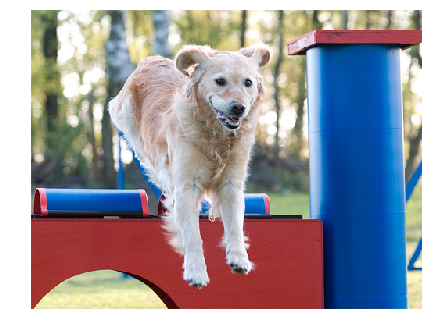

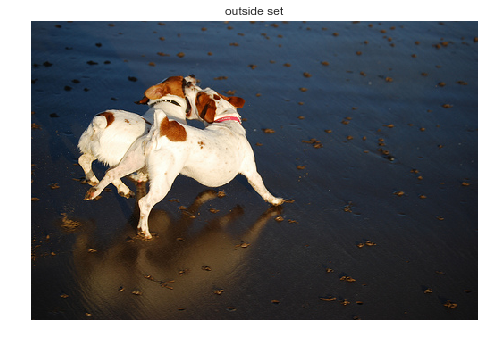

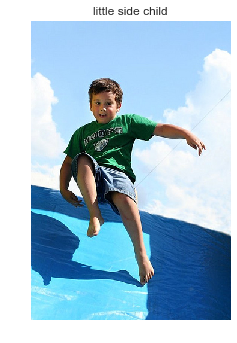

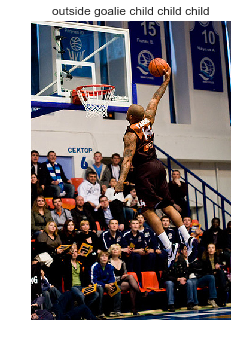

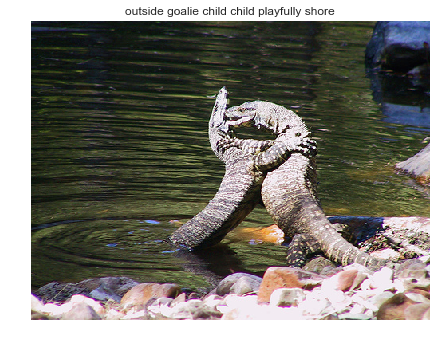

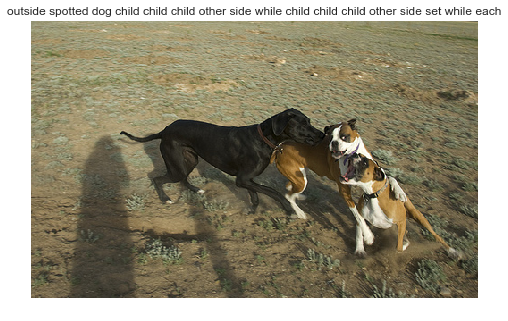

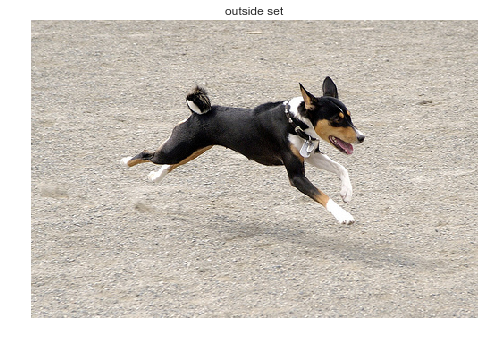

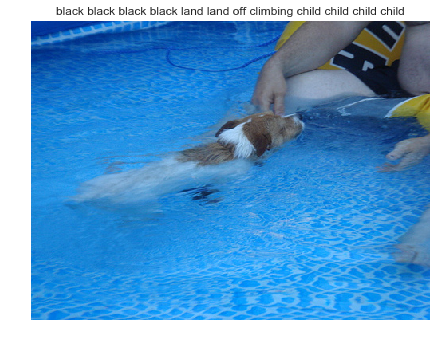

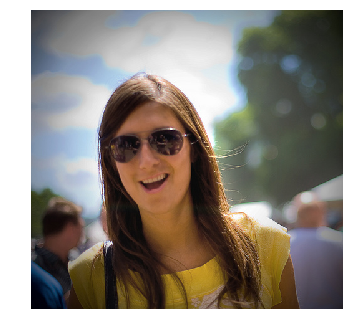

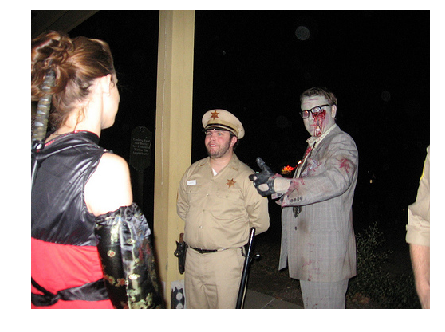

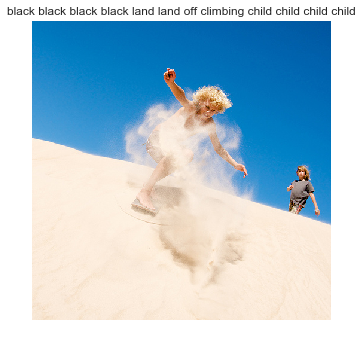

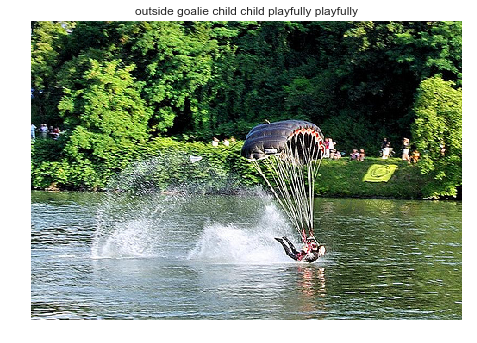

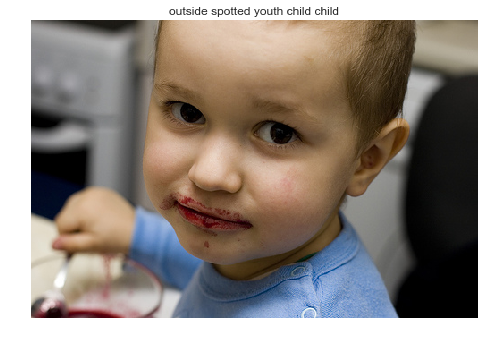

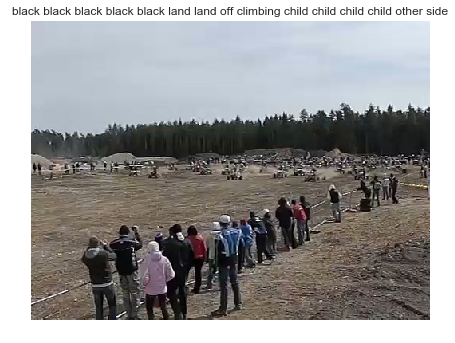

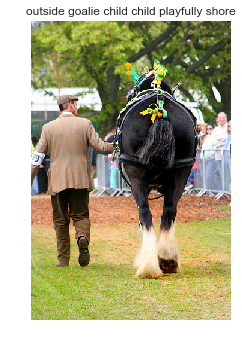

In [251]:
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("./Flickr_Data/Flickr_Data/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()